# Using Multiple Features to Predict Origins of Wine Bottles

## Introduction

## Getting Started

The files `wine.data` needs to be downloaded from http://archive.ics.uci.edu/ml/machine-learning-databases/wine/ and placed in the directory `./data`. For ease, this dataset has been already uploaded to this repository.

Import the libraries that will be used in the notebook. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from scipy.stats import norm, multivariate_normal

## Reading, cleaning and exploring the data

This part of the notebook follows the same route as that same part in the notebook entitled `1-univariate-generative.ipynb`.

Read the data and put into a Pandas dataframe.

In [2]:
X = pd.read_csv('./data/wine.data', sep=",", header=None)

Check to see the contents of the first few rows of the dataset.

In [3]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


The first column is the label of which winery the wine came from: Winery 1, Winery 2 and Winery 3. The other 13 columns are the 13 features of each wine bottle are shown below:

In [4]:
features = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols', 
                'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 
                'OD280/OD315 of diluted wines', 'Proline']

Set the columns to have appropriate names.

In [5]:
X.columns = ['Winery'] + features

Define our target labels.

In [6]:
y = X['Winery']

Before the data is split into train/test sets, it will be beneficial to add another column to the data called `Winery_Label`. This label will aid in creating bivariate plots using seaborn.

In [7]:
labels = X['Winery'].tolist()
winery_labels = ['Winery ' + str(x) for x in labels]
X['Winery_Label'] = winery_labels

Use the function train_test_split from the package sklearn.model_selection to split the data into train data and test data. 33% of the data will be left for the purposes of testing the model.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Creating bivariate plots of the data

Seaborn can be used to create bivariate plots of any given to features. The function below does exactly this.

In [9]:
def plot_bivariate(feature_1, feature_2):
    '''This function plots a bivariate plot with feature_1 on the x axis and 
        feature_2 on the y axis.'''

    sns.scatterplot(data=X_train, x=feature_1, y=feature_2,
                hue='Winery_Label', hue_order =['Winery 1', 'Winery 2', 'Winery 3'])
    
    # Move the legend out of the plot and change the title of the legend
    plt.legend(bbox_to_anchor=(1, 1)).texts[0].set_text('Winery')
    plt.title('Plot of '+feature_2+' vs '+feature_1);


Using the function above, a bivariate plot can be produced for the features Alcohol and Ash.

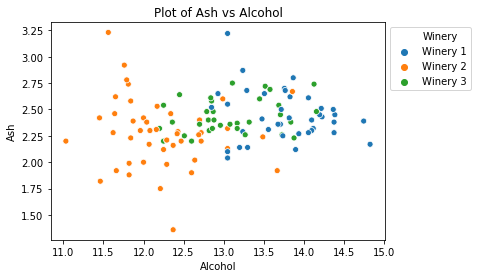

In [10]:
plot_bivariate('Alcohol', 'Ash')

## Using a bivariate normal distribution to model features

One feature can be modelled as a *univariate* normal distribution with a given mean and **standard deviation**. Two features can be modelled with a *bivariate* normal distribution with a given mean and a 2 x 2 **covariance matrix**. The covariance matrix encodes the standard deviation of both of the two features and how highly correlated these features are. 

In order to use a bivariate normal distribution to model two chosen features, the function below is used to return the mean and covariance for two features for a given winery.

In [11]:
def mean_and_cov(df, features, winery_number):
    """ For example, mean_and_cov(X_training, ['Alcohol', 'Ash'], 1) returns the mean and 
        covariance matrix for the alcohol and ash features for wines belonging
        to Winery 1 in the training data."""
    
    winery_filter = df['Winery'] == winery_number
    
    mean = df[winery_filter][features].mean()
    cov = df[winery_filter][features].cov()

    return mean, cov

The function below plots a bivariate normal distribution that can model the distribution of two of the features. It requires a data frame, a winery number and x and y limits for the plot.

In [12]:
def plot_bivariate(df, features, winery_number, x_limits, y_limits):
    """For example, the call:
    plot_bivariate(X_train, ['Alcohol', 'Ash'], 1, [10,15], [0,5]) 
    will plot a bivariate normal distribution that models the Alcohol on the x-axis and
    Ash on the y-axis. It will only include wines from Winery 1 and it will have an x-range
    of [10,15] and a y-range of [0,5]"""
    
    # Obtain the mean and covariance matrix for the two features.
    mean, cov = mean_and_cov(df, features, winery_number)
    
    # Use multivariate_normal from scipy.stats library to define an object that has the 
    # potential to be evaluated.
    rv = multivariate_normal(mean, cov)
    
    # Define x and y lists with the required ranges.   
    x = np.linspace(x_limits[0], x_limits[1], 100)
    y = np.linspace(y_limits[0], y_limits[1], 100)
    
    # The code below creates a grid Z[i,j] and evaluates the bivariate normal distribution
    # on it.
    
    X, Y = np.meshgrid(x, y)
    Z = np.zeros((x.size, y.size))
    
    for i in range(x.size):
        for j in range(y.size):
            Z[i,j] = rv.pdf([X[i,j],Y[i,j]])
    
    # A heatmap can be drawn of the grid.
    
    plt.pcolor(X, Y, Z, cmap='Reds')
    plt.colorbar()

    title = 'Winery '+str(winery_number)+'\n Bivariate Normal Distribution \n' + features[1] + ' vs ' + features[0]      
    plt.title(title)
    plt.xlabel(features[0])          
    plt.ylabel(features[1])
           
    plt.show()
    plt.close()

Having defined the function `plot_bivariate`, the bivariate normal distribution can be plotted for all the wines in each of the three wineries. 

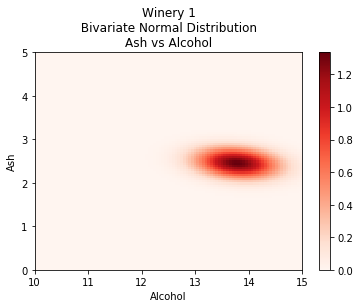

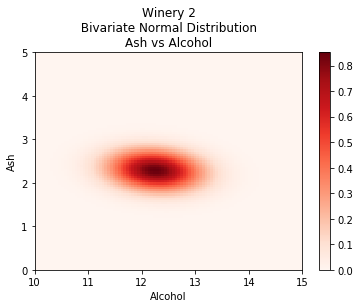

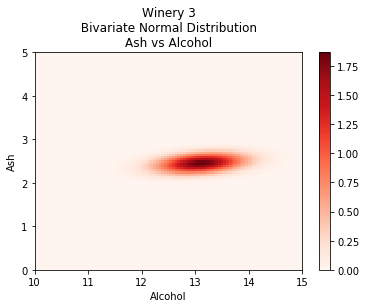

In [13]:
for winery in [1,2,3]:
    plot_bivariate(X_train, ['Alcohol', 'Ash'], winery, [10,15], [0,5])

## Fitting a Multivariate Gaussian Generative Model

Given the X_train dataset, if a list of features were to be selected, a multivariate gaussian generative model could be created by first determining the mean, covariance matrix and pi values for each of the three wineries. The pi value for a given winery represents the fraction of total wines that are from this given winery in the data.

In [14]:
def fit_generative_model(df, features):
    """The fit_generative_model takes a dataframe, such as X_train, and a list of features
       and returns three lists. The first list is a list of the means for the three 
       wineries. The other two lists contain the covariance matrices and pi values for
       the three wineries."""

    # Initialise the lists that will be returned by the function.
    
    means = []
    covs = []
    pis = []
    
    total_number_of_wines = df.shape[0]
    
    for i in [0,1,2]:     
    
        means.append(df[df['Winery'] == i+1][features].mean())
        
        covs.append(df[df['Winery'] == i+1][features].cov())
    
        # NB: The loop and list is zero indexed, but the name of the winery is not.
        number_of_wines_in_winery = df[df['Winery'] == i+1].shape[0]                      
    
        pis.append(number_of_wines_in_winery/total_number_of_wines)
    
    return means, covs, pis

Now that the means, covariance matrices and pi values can be determined for each winery and any given selection of features, predictions can be made for each of the wine bottles in the test data.

Given a wine bottle from the test data, it will be classified as the winery that maximises the probability:

probability = (pi value of the winery) x (the wines 'location' on the multivariate normal distribution for the winery) 

In [15]:
def predict_model(df, features):
    """The function predict_model takes in a dataframe, such as X_test, and a list of
    features and returns a list of predictions using a multivariate Gaussian generative
    model."""
    
    # Obtain the means, covariance matrices and pi values for the given features.
    means, covs, pis = fit_generative_model(X_train, features)

    # Initialise an empty list that will contain the predictions.
    predictions = []
    
    # The following for loop iterates down the rows of the dataframe,
    # adding predictions for each row to the list predictions.
    for index, row in df[features].iterrows():
        
        # Intialise an empty list that will contain the probabilities for each of the three
        # wineries.
        probabilities = []
        
        # Loop through each of the wineries, zero indexed, and determine the probability of
        # it belonging to the winery. 
        for i in [0,1,2]:
            
            probabilities.append(pis[i]*multivariate_normal(means[i], covs[i]).pdf(row))
        
        # The predicted label will be the winery that has the maximum probability. 
        prediction = np.argmax(probabilities)
        
        # NB: The loop and list is zero indexed, but the name of the winery is not.
        # This is why one is added.
        predictions.append(prediction+1)
        
    return predictions

Predictions can be made by using the three features: 'Alcohol', 'Ash' and 'Proline'. As can be seen below, the accuracy of the predictions is 88%.

In [16]:
predictions = predict_model(X_test, ['Alcohol', 'Ash', 'Proline'])
correct_labels = y_test

accuracy_score(correct_labels, predictions)

0.8813559322033898

A multivariate Gaussian generative model can be created for all of the thirteen features. When this is done, an impressive 98% accuracy is achieved on the test dataset. 

In [17]:
predictions = predict_model(X_test, features)
correct_labels = y_test.tolist()

accuracy_score(correct_labels, predictions)

0.9830508474576272

## Conclusion

In this notebook, a multivariate Gaussian generative model was created. This model was used to classify the origins of wine bottles from three wineries. A bivariate plot of the features Alcohol and Ash was created. This then allowed more powerful generalisation of plotting a bivariate normal distribution of any given two features. Finally, a multivariate Gaussian generative model was constructed for an arbitraty amount of the thirteen features. The multivariate model was constructed by first determining the means, covariance matrices and pi values for each of the three wineries. The model could then be used to predict the  winery of origin for each of the the wines on the test set. It was found that the accuracy of this classification was 98%.

## References

Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Dasgupta, S. (2019). EDX Course: Machine Learning Fundamentals. UCSanDiegoX. Retrieved from https://www.edx.org/course/machine-learning-fundamentals-3
